In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
df = pd.read_csv('/content/gdrive/My Drive/ecommerce_reviews.csv')
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [4]:
df = df.drop(['Title', 'Positive Feedback Count', 'Unnamed: 0', ], axis=1)
df.dropna(inplace=True)
df

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses
2,1077,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses
...,...,...,...,...,...,...,...,...
23481,1104,34,I was very happy to snag this dress at such a ...,5,1,General Petite,Dresses,Dresses
23482,862,48,"It reminds me of maternity clothes. soft, stre...",3,1,General Petite,Tops,Knits
23483,1104,31,"This fit well, but the top was very see throug...",3,0,General Petite,Dresses,Dresses
23484,1084,28,I bought this dress for a wedding i have this ...,3,1,General,Dresses,Dresses


In [5]:
df['Polarity_Rating'] = df['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))
df

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name,Polarity_Rating
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,Positive
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,Positive
2,1077,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses,Neutral
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,Positive
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,Positive
...,...,...,...,...,...,...,...,...,...
23481,1104,34,I was very happy to snag this dress at such a ...,5,1,General Petite,Dresses,Dresses,Positive
23482,862,48,"It reminds me of maternity clothes. soft, stre...",3,1,General Petite,Tops,Knits,Neutral
23483,1104,31,"This fit well, but the top was very see throug...",3,0,General Petite,Dresses,Dresses,Neutral
23484,1084,28,I bought this dress for a wedding i have this ...,3,1,General,Dresses,Dresses,Neutral


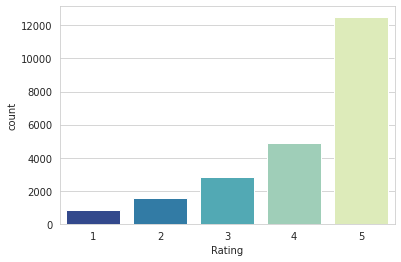

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Rating',data=df, palette='YlGnBu_r')

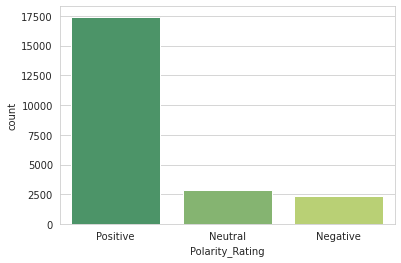

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Polarity_Rating',data=df, palette='summer')

In [8]:
df_Positive = df[df['Polarity_Rating'] == 'Positive'][0:8000]
df_Neutral = df[df['Polarity_Rating'] == 'Neutral']
df_Negative = df[df['Polarity_Rating'] == 'Negative']

In [9]:
df_Neutral_over = df_Neutral.sample(8000, replace=True)
df_Negative_over = df_Negative.sample(8000, replace=True)
df = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis=0)

In [10]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [11]:

df['review'] = df['Review Text'].apply(get_text_processing)
df

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name,Polarity_Rating,review
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,Positive,Absolutely wonderful silky sexy comfortable
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,Positive,Love dress sooo pretty happened find store im ...
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,Positive,love love love jumpsuit fun flirty fabulous ev...
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,Positive,shirt flattering due adjustable front tie perf...
6,858,39,I aded this in my basket at hte last mintue to...,5,1,General Petite,Tops,Knits,Positive,aded basket hte last mintue see would look lik...
...,...,...,...,...,...,...,...,...,...,...
22650,895,42,I also expected this sweater to have more bulk...,2,0,General,Tops,Fine gauge,Negative,also expected sweater bulk per images thin oth...
3820,828,83,I saw this top online and ordered immediately!...,1,0,General,Tops,Blouses,Negative,saw top online ordered immediately loved color...
15037,1087,25,This dress looks so cute in the pictures-i lov...,2,0,General,Dresses,Dresses,Negative,dress looks cute picturesi love style ordered ...
13440,1125,33,"I ordered this coat because, like others, i wa...",2,0,General Petite,Jackets,Outerwear,Negative,ordered coat like others taken feminine beauty...


In [12]:
df = df[['review', 'Polarity_Rating']]
df

,review,Polarity_Rating
0,Absolutely wonderful silky sexy comfortable,Positive
1,Love dress sooo pretty happened find store im ...,Positive
3,love love love jumpsuit fun flirty fabulous ev...,Positive
4,shirt flattering due adjustable front tie perf...,Positive
6,aded basket hte last mintue see would look lik...,Positive
...,...,...
22650,also expected sweater bulk per images thin oth...,Negative
3820,saw top online ordered immediately loved color...,Negative
15037,dress looks cute picturesi love style ordered ...,Negative
13440,ordered coat like others taken feminine beauty...,Negative


In [13]:
one_hot = pd.get_dummies(df["Polarity_Rating"])
df.drop(['Polarity_Rating'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,review,Negative,Neutral,Positive
0,Absolutely wonderful silky sexy comfortable,0,0,1
1,Love dress sooo pretty happened find store im ...,0,0,1
3,love love love jumpsuit fun flirty fabulous ev...,0,0,1
4,shirt flattering due adjustable front tie perf...,0,0,1
6,aded basket hte last mintue see would look lik...,0,0,1
...,...,...,...,...
22650,also expected sweater bulk per images thin oth...,1,0,0
3820,saw top online ordered immediately loved color...,1,0,0
15037,dress looks cute picturesi love style ordered ...,1,0,0
13440,ordered coat like others taken feminine beauty...,1,0,0


In [14]:
x = df['review'].values
y = df.drop('review', axis=1).values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [15]:
vect = CountVectorizer()
x_train = vect.fit_transform(x_train)
x_test = vect.transform(x_test)

In [16]:
tfidf = TfidfTransformer()
x_train = tfidf.fit_transform(x_train)
x_test = tfidf.transform(x_test)
x_train = x_train.toarray()
x_test = x_test.toarray()

In [17]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [18]:
model.fit(x_train, y_train, batch_size=256, epochs=5, validation_data=(x_test, y_test), verbose=1, callbacks=early_stop)

Epoch 1/5
66/66 [==============================] - 409s 6s/step - loss: 0.7970 - accuracy: 0.6159 - val_loss: 0.3365 - val_accuracy: 0.8725
Epoch 2/5
66/66 [==============================] - 408s 6s/step - loss: 0.1192 - accuracy: 0.9616 - val_loss: 0.2699 - val_accuracy: 0.9164
Epoch 3/5
66/66 [==============================] - 403s 6s/step - loss: 0.0215 - accuracy: 0.9936 - val_loss: 0.3303 - val_accuracy: 0.9208
Epoch 4/5
66/66 [==============================] - 402s 6s/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.3724 - val_accuracy: 0.9228
Epoch 00004: early stopping


In [19]:
model_score = model.evaluate(x_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

113/113 [==============================] - 62s 546ms/step - loss: 0.3724 - accuracy: 0.9228
Test accuracy: 0.9227777719497681


In [20]:
preds = model.predict(x_test)
preds

array([[2.14730322e-09, 1.44335090e-07, 9.99999881e-01],
       [1.55531261e-02, 3.18428688e-03, 9.81262624e-01],
       [9.99748290e-01, 1.20161691e-04, 1.31615598e-04],
       ...,
       [9.98653412e-01, 8.90455500e-04, 4.56107140e-04],
       [9.39054612e-09, 3.05924353e-08, 1.00000000e+00],
       [1.01241824e-07, 2.72378543e-06, 9.99997139e-01]], dtype=float32)